# Imports

In [1]:
# Only required if using Google Colab and Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import statistics
import cv2
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)

# Load data

In [3]:
DATA_FOLDER = # ADD DATA FOLDER PATH, e.g. '/content/drive/MyDrive/Project_Name/data/'

In [4]:
# Sample images for visualization

SAMPLE_IMG_DIR = DATA_FOLDER+'sample_images'
SAMPLE_IMG_LST = [os.path.basename(fname) for fname in sorted(glob(SAMPLE_IMG_DIR+"/*.jpg"))]

print(SAMPLE_IMG_LST)
print(len(SAMPLE_IMG_LST))

['1000254916_5.jpg', '1068899298_4.jpg', '1069198750_1.jpg', '1069198766_7.jpg', '108229725_3.jpg', '117467571_9.jpg', '197183074_3.jpg', '808449785_3_left.jpg', '844802792_3_left.jpg', '930961707_1_left.jpg']
10


In [5]:
# Load dataframe of post-NMS inference for all detections

nms_inf_df = pd.read_excel(DATA_FOLDER+'full_inference_results_post_NMS.xlsx')
nms_inf_df['osm_id'] = nms_inf_df['image_id'].apply(lambda x: x.split('_')[0])
nms_inf_df

,image_id,category_id,image_width,image_height,score,x_min_norm,y_min_norm,x_max_norm,y_max_norm,x_min,y_min,x_max,y_max,area,osm_id
0,863796903_4_left,0,867,594,1.000000,0.004088,0.109253,0.999894,0.698347,3.544296,64.896282,866.908098,414.818118,302109.846732,863796903
1,863796903_4_left,1,867,594,0.918414,0.468974,0.156618,0.545802,0.301412,406.600848,93.031092,473.209944,179.038728,5728.890857,863796903
2,863796903_4_left,1,867,594,0.902896,0.149780,0.153991,0.260680,0.293610,129.858826,91.470357,226.009994,174.404043,7974.170693,863796903
3,863796903_4_left,1,867,594,0.897758,0.894700,0.161575,0.943454,0.298123,775.705030,95.975253,817.974488,177.085359,3428.480211,863796903
4,863796903_4_left,1,867,594,0.880096,0.893276,0.515027,0.943516,0.602003,774.470119,305.926276,818.028545,357.589544,2250.370712,863796903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32466,864047705_6,1,373,401,0.903789,0.181230,0.159476,0.247664,0.249496,67.598902,63.949736,92.378560,100.048036,894.503553,864047705
32467,864047705_6,1,373,401,0.899852,0.188648,0.361882,0.254553,0.451601,70.365890,145.114482,94.948455,181.091801,884.414783,864047705
32468,864047705_6,1,373,401,0.883129,0.630071,0.156632,0.690499,0.248212,235.016446,62.809252,257.556164,99.533192,827.747294,864047705
32469,864047705_6,1,373,401,0.854981,0.792208,0.154026,0.856202,0.243828,295.493565,61.764446,319.363365,97.775008,859.564885,864047705


In [6]:
# Load dataframe of OSM buildings where OSM line lengths are within +/- 10% of line lengths in the municipal dataset

osm_to_detect = pd.read_excel(DATA_FOLDER+'osm_buildings_for_story_height_detection.xlsx')
osm_to_detect

,osm_id,osm_id_final,image_id,Start_Lon,Start_Lat,End_Lon,End_Lat,Center_Lon,Center_Lat,LINE_LENGTH,LINE_BEARING,Line_Bearing_Normal,osm_polygon_length,osm_polygon_area,CIT_AR,Era,Main_Class,Final_Class,GFA,line_length_muni,no_stories_muni,bldg_height_muni
0,1214584628,1214584628_3,1214584628_3,7.700270,45.110234,7.700304,45.110367,7.700287,45.110300,15.035877,10.064707,280.064707,56.696386,199.201230,122974,4,TH,R4TH,398.402461,15.590464,2,8.380000
1,808447125,808447125_2,808447125_2,7.691719,45.096307,7.691275,45.096413,7.691497,45.096360,36.877279,288.705666,198.705666,94.917499,246.043862,142371,3,AB,R3AB,984.175446,38.214881,4,14.190000
2,769086114,769086114_4,769086114_4_sc,7.702434,45.083162,7.702257,45.083354,7.702346,45.083258,25.468718,327.041653,237.041653,77.725917,341.132545,145458,4,AB,R4AB,2387.927817,25.177156,7,23.350000
3,930680502,930680502_6,930680502_6,7.698868,45.090518,7.699190,45.090429,7.699029,45.090474,27.202734,111.386536,21.386536,101.360876,533.860578,155297,4,AB,R4AB,3737.024047,24.839198,7,23.469999
4,930680549,930680549_4,930680549_4,7.702899,45.090113,7.703070,45.090074,7.702985,45.090094,14.150399,107.797486,17.797486,54.236504,193.638974,155889,5,AB,R5AB,968.194872,15.663844,5,18.070000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,863793544,863793544_1,863793544_1,7.747931,45.102446,7.747770,45.102427,7.747851,45.102436,12.869689,260.525673,170.525673,55.178647,189.444138,85291,6,SF,R6SF,189.444138,12.051110,1,4.430000
593,863796950,863796950_1,863796950_1,7.749163,45.102563,7.748970,45.102542,7.749067,45.102553,15.380699,261.327382,171.327382,54.642240,183.651788,85352,4,TH,R4TH,367.303576,15.713994,2,8.030000
594,865260698,865260698_6,865260698_6,7.744370,45.102013,7.744086,45.101986,7.744228,45.101999,22.590408,262.227687,172.227687,66.086322,256.852187,86701,5,AB,R5AB,1284.260934,22.032300,5,18.250000
595,863796936,863796936_3,863796936_3,7.745368,45.103975,7.745395,45.104100,7.745382,45.104037,14.039927,8.612090,278.612090,53.896503,181.225559,86710,5,TH,R5TH,362.451119,14.110724,2,6.780000


# Define functions

In [7]:
def get_pred_mask(image_id, show_plot=False):
    """
    Function convert df to mask where 'category_id' == 1 or ==2 become white pixels, and all other pixels are black.
    Used as part of the workflow to count building stories in facade images based on window detections.

    Arguments:
    image_id              --  string; a unique image identifier.
    show_plot             --  Boolean; set to True if images should be plotted using matplotlib.

    Returns:
    mask_pred             --  numpy array; binary mask where values are 255 where predicted windows or garage doors are present, and 0 for all other pixels.
    """
    # Make a temporary df called pred_df with all post-NMS object detections
    pred_df = nms_inf_df.loc[nms_inf_df['image_id']==image_id].copy().reset_index(drop=True)
    h = int(pred_df['image_height'].values[0])
    w = int(pred_df['image_width'].values[0])

    # Initialize the mask, mask_pred, as an array of zeros in the same size of the original image.
    mask_pred = np.zeros((h,w))

    # Iterate through pred_df, if these are windows or garage doors, set the pixel values to 255.
    for i in range(len(pred_df)):
        if pred_df['category_id'][i] == 1 or pred_df['category_id'][i] == 2:
          x_min = int(pred_df['x_min_norm'][i]*w)
          y_min = int(pred_df['y_min_norm'][i]*h)
          x_max = int(pred_df['x_max_norm'][i]*w)
          y_max = int(pred_df['y_max_norm'][i]*h)
          mask_pred[y_min:y_max, x_min:x_max] = 255

    if show_plot == True:
      plt.imshow(mask_pred, cmap='gray')

    return mask_pred


def split_vertical(mask, show_plot=False):
    """
    Function to split image into vertical strips, including each of these as a separate mask in the returned mask_lst.

    The vertical strips are subsequently used to count the number of rows of windows, used to determine number of bldg stories.

    Arguments:
    mask                  --  numpy array; binary mask where values are 255 where predicted windows or garage doors are present, and 0 for all other pixels.
    show_plot             --  Boolean; set to True if images should be plotted using matplotlib.

    Returns:
    mask_lst              --  list; list of masks, where each mask is a numpy array. Each mask in the list is a vertical strip for the facade, based on vertical
                              columns of windows from the input mask.
    """
    # Get sum of values in columns of image to split vertically.
    split_vert = np.sum(mask, axis=0)

    # The max_y is used to avoid index errors when running the for loop below.
    max_y = mask.shape[1] - 1

    # Run for loop to get indexes of start and end columns in image
    # where glazing is present (glazing is present if sum of column value > 0).
    prev_i = 0
    start_lst = []
    end_lst = []
    for i in range(len(split_vert)):
      if (split_vert[i] > 0 and split_vert[prev_i] == 0) or (split_vert[i]>0 and i==0):
        start_lst.append(i)
      if split_vert[i] == 0 and split_vert[prev_i] > 0 or (split_vert[i]>0 and i==max_y):
        end_lst.append(i)
      prev_i = i
    # Iterate through start_lst to create masks in vertical strips, only where glazing is present
    mask_lst = []
    for i in range(len(start_lst)):
      mask_lst.append(mask[:,start_lst[i]:end_lst[i]])

    if show_plot == True:
      for i in range(len(mask_lst)):
        plt.subplot(1,len(mask_lst),i+1)
        plt.imshow(mask_lst[i], cmap='gray')
    return mask_lst


def split_horizontal(mask_lst, show_plot=False):
    """
    # Function to split list of mask images into horizontal strips, as part of the workflow to count number of building stories.
    # Based on indexes of start and end rows in image where glazing is present (glazing is present if sum of row value > 0).
    # Then makes dictionary for each row of glazing in each vertically split mask to include the start_lst and end_lst for each.

    Arguments:
    mask_lst              --  list; list of masks, where each mask is a numpy array. Each mask in the list is a vertical strip for the facade, based on vertical
                              columns of windows from the input mask.
    show_plot             --  Boolean; set to True if images should be plotted using matplotlib.

    Returns:
    idx_dict              --  dictionary; the dictionary holds the pixel values where rows of windows start and end. This is subsequently used to calculated
                              number of rows of windows, which is a proxy for number of building stories.
    """
    idx_dict = {}
    # Iterate through mask_lst, each of the input masks is a vertical strip based on the input mask.
    for i in range(len(mask_lst)):
      # Create split_horiz, which stores the sum of values in rows of input mask.
      # Rows with sum = 0 have no windows, rows with sum > 0 have windows.
      split_horiz = np.sum(mask_lst[i], axis=1)

      # Initialize variables and lists
      prev_j = 0
      start_lst = []
      end_lst = []

      # Iterate through split_horiz to determine which pixel number windows start and end at.
      for j in range(len(split_horiz)):
        if split_horiz[j] > 0 and split_horiz[prev_j] == 0:
          start_lst.append(j)
        if split_horiz[j] == 0 and split_horiz[prev_j] > 0:
          end_lst.append(j)
        # Extra elif statement in case the window/garage extends to bottom of cropped image.
        elif j == len(split_horiz)-1 and split_horiz[j] > 0:
          end_lst.append(j)
        prev_j = j
      # Create dictionary to return start and end indexes of rows of windows.
      idx_dict[i] = {'start_lst':start_lst, 'end_lst':end_lst}

    if show_plot == True:
      img_lst = []
      for i in range(len(mask_lst)):
        # Concatenate mask_lst[i] to enable plot as color image so it has dimensions WxHx3
        img = np.expand_dims(mask_lst[i], axis=2)
        img = np.concatenate((img, img, img), axis=2)
        # Add colored horizontal line to show where row breaks
        for j in range(len(idx_dict[i]['start_lst'])):
          img = cv2.line(img, (0, idx_dict[i]['start_lst'][j]), (img.shape[1], idx_dict[i]['start_lst'][j]), (0,255,0), 2)
        img_lst.append(img)
      # Show subplots
      for i in range(len(img_lst)):
        img = img_lst[i]
        img = cv2.rectangle(img, (0,0), (img.shape[1],img.shape[0]), (0,0,255), 2)
        ax = plt.subplot(1,len(img_lst),i+1)
        plt.axis('off')
        plt.imshow(img.astype(np.uint8))
    return idx_dict


def get_stories(image_id, show=False, report=False):
    """
    Wrapper function to call all above functions.

    Arguments:
    image_id              --  string; a unique image identifier.
    show                  --  Boolean; set to True if images should be plotted using matplotlib.
    report                --  Boolean; set to True if the number of stories should be printed on screen.

    Returns:
    num_stories           --  int; the number of building stories estimated by the functions.
    """
    mask_pred = get_pred_mask(image_id, show_plot=False)
    msk_lst = split_vertical(mask_pred, show_plot=False)
    row_dict = split_horizontal(msk_lst, show_plot=show)

    # Get the length of start_lst and end_lst, i.e. how many start points and end points within each list.
    start_lengths = [len(row_dict[i]['start_lst']) for i in range(len(row_dict))]
    end_lengths = [len(row_dict[i]['end_lst']) for i in range(len(row_dict))]
    # If the lists start_lengths and end_lengths are empty, return False.
    if not start_lengths and not end_lengths:
      return False
    else:
      # Get the mode from start_ and end_lengths, i.e. the most occuring number of start/end points.
      start_mode = statistics.mode(start_lengths)
      end_mode = statistics.mode(end_lengths)
      # Set number of stories equal to the max of the start_mode or end_mode.
      if start_mode > end_mode:
        num_stories = start_mode
      else:
        num_stories = end_mode
      if report == True:
        print('number of stories: ', num_stories)
      return num_stories


def calc_bldg_height(image_id, report=False):
    """
    Function to calculate buiding heights using wall length in meters, i.e. "LINE_LENGTH" in the OSM database.
    Based on pixel ratio of detected wall height to wall width, multiplied by the wall length in metrs from the GIS database.

    Arguments:
    image_id              --  string; a unique image identifier.
    report                --  Boolean; set to True if the building height should be printed on screen.

    Returns:
    wall_height_m         --  float; the estimated building height, in meters.
    """
    pred_df = nms_inf_df.loc[nms_inf_df['image_id']==image_id].copy().reset_index(drop=True)
    id_final = image_id.split('_')[0] + '_' + image_id.split('_')[1]
    wall_x_min = float(pred_df.loc[pred_df['category_id']==0, 'x_min'].values[0])
    wall_y_min = float(pred_df.loc[pred_df['category_id']==0, 'y_min'].values[0])
    wall_x_max = float(pred_df.loc[pred_df['category_id']==0, 'x_max'].values[0])
    wall_y_max = float(pred_df.loc[pred_df['category_id']==0, 'y_max'].values[0])

    # Establish wall height and width in pixels.
    wall_height_px = wall_y_max - wall_y_min
    wall_width_px = wall_x_max - wall_x_min

    # Convert height from pixels to meters based on wall length from GIS database.
    wall_length_m = osm_to_detect.loc[osm_to_detect['osm_id_final']==id_final, 'LINE_LENGTH'].values[0]
    wall_height_m = wall_height_px / wall_width_px * wall_length_m

    if report == True:
      print('id_final: ', id_final)
      print('wall height in pixels: ', wall_height_px)
      print('wall width in pixels: ', wall_width_px)
      print('wall length in meters in OSM database: ', wall_length_m)
      print('calculated wall height in meters: ', wall_height_m)
      print('____________________________________________')
    return wall_height_m


def plot_results(image_id, dataframe, show_plot=False, save_file=False, save_dir=None):
    """
    Function to plot detected bounding boxes onto input images.
    Not required for height/story detection, but to visualize original images.

    Arguments:
    image_id              --  string; a unique image identifier.
    dataframe             --  pd.DataFrame; a dataframe with detections, typically the post-NMS inference dataframe.
    show_plot             --  Boolean; set to True if images should be plotted using matplotlib.
    save_file             --  Boolean; set to True if images with bounding box plots should be saved.
    save_dir              --  string; path to directory where image should be saved.

    Returns:
    img_w_boxes           --  numpy array; a numpy array image of bounding boxes plotted onto original image, in color.
    """

    box_df = dataframe.loc[dataframe['image_id']==image_id].reset_index()
    img_dir = SAMPLE_IMG_DIR
    img_path = os.path.join(img_dir, image_id+'.jpg')
    img = cv2.imread(img_path)
    img_w_boxes = img.copy()


    for row in range(len(box_df.index)):
      label = int(box_df.at[row,'category_id'])
      xmin = int(box_df.at[row,'x_min'])
      ymin = int(box_df.at[row,'y_min'])
      xmax = int(box_df.at[row,'x_max'])
      ymax = int(box_df.at[row,'y_max'])

      if label == 0: #wall
        color = (255,0,0)
      elif label == 1: # window
        color = (0,255,0)
      elif label == 2: #garage
        color = (0,0,255)
      img_w_boxes = cv2.rectangle(img_w_boxes,(xmin, ymin), (xmax, ymax), color, 2)

    img_w_boxes = cv2.cvtColor(img_w_boxes, cv2.COLOR_BGR2RGB)

    if show_plot==True:
      plt.axis("off")
      plt.imshow(img_w_boxes)

    if save_file==True:
      save_path = os.path.join(save_dir, image_id+'.jpg')
      cv2.imwrite(save_path, img_w_boxes)

    return img_w_boxes

# Test example with stories and height detection

197183074_3


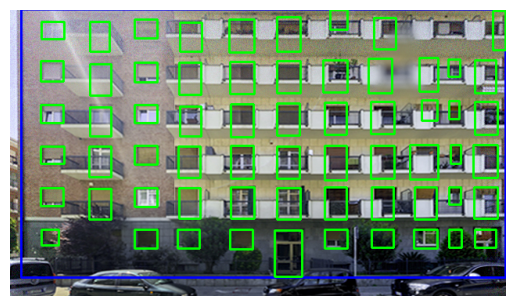

In [8]:
# Test examples from the SAMPLE_IMG_LST

check_id = SAMPLE_IMG_LST[6][:-4]
print(check_id)
check_img = plot_results(check_id, nms_inf_df, show_plot=True)

number of stories:  6


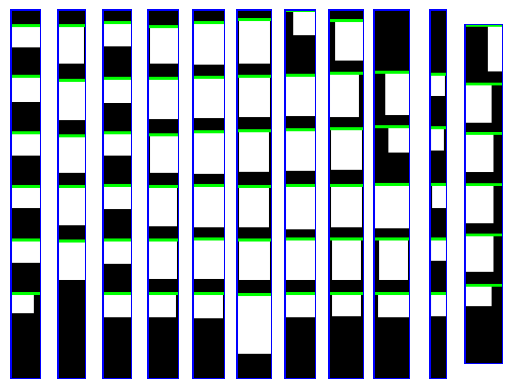

In [9]:
# Use get_stories function to return number of stories

check_stories = get_stories(check_id, show=True, report=True)

In [10]:
# Use calc_bldg_height function to return building height

calc_bldg_height(check_id, report=True)

id_final:  197183074_3
wall height in pixels:  342.4292339999999
wall width in pixels:  618.478412
wall length in meters in OSM database:  51.30560500501203
calculated wall height in meters:  28.4060666967513
____________________________________________


np.float64(28.4060666967513)

# Run for loop to calculate stories & height

In [13]:
df_lst = []
for img_id in osm_to_detect['image_id'].unique():
  tmp_df = osm_to_detect.loc[osm_to_detect['image_id']==img_id].copy().reset_index(drop=True)
  no_stories = get_stories(img_id)
  tmp_df['stories_detected'] = no_stories
  bldg_height = calc_bldg_height(img_id)
  tmp_df['height_detected'] = bldg_height
  df_lst.append(tmp_df)
detected = pd.concat(df_lst, ignore_index=True)
detected

,osm_id,osm_id_final,image_id,Start_Lon,Start_Lat,End_Lon,End_Lat,Center_Lon,Center_Lat,LINE_LENGTH,LINE_BEARING,Line_Bearing_Normal,osm_polygon_length,osm_polygon_area,CIT_AR,Era,Main_Class,Final_Class,GFA,line_length_muni,no_stories_muni,bldg_height_muni,stories_detected,height_detected
0,1214584628,1214584628_3,1214584628_3,7.700270,45.110234,7.700304,45.110367,7.700287,45.110300,15.035877,10.064707,280.064707,56.696386,199.201230,122974,4,TH,R4TH,398.402461,15.590464,2,8.380000,2,7.621552
1,808447125,808447125_2,808447125_2,7.691719,45.096307,7.691275,45.096413,7.691497,45.096360,36.877279,288.705666,198.705666,94.917499,246.043862,142371,3,AB,R3AB,984.175446,38.214881,4,14.190000,4,14.441950
2,769086114,769086114_4,769086114_4_sc,7.702434,45.083162,7.702257,45.083354,7.702346,45.083258,25.468718,327.041653,237.041653,77.725917,341.132545,145458,4,AB,R4AB,2387.927817,25.177156,7,23.350000,6,21.599589
3,930680502,930680502_6,930680502_6,7.698868,45.090518,7.699190,45.090429,7.699029,45.090474,27.202734,111.386536,21.386536,101.360876,533.860578,155297,4,AB,R4AB,3737.024047,24.839198,7,23.469999,5,26.839529
4,930680549,930680549_4,930680549_4,7.702899,45.090113,7.703070,45.090074,7.702985,45.090094,14.150399,107.797486,17.797486,54.236504,193.638974,155889,5,AB,R5AB,968.194872,15.663844,5,18.070000,5,16.710881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,863793544,863793544_1,863793544_1,7.747931,45.102446,7.747770,45.102427,7.747851,45.102436,12.869689,260.525673,170.525673,55.178647,189.444138,85291,6,SF,R6SF,189.444138,12.051110,1,4.430000,1,5.825258
593,863796950,863796950_1,863796950_1,7.749163,45.102563,7.748970,45.102542,7.749067,45.102553,15.380699,261.327382,171.327382,54.642240,183.651788,85352,4,TH,R4TH,367.303576,15.713994,2,8.030000,2,8.029559
594,865260698,865260698_6,865260698_6,7.744370,45.102013,7.744086,45.101986,7.744228,45.101999,22.590408,262.227687,172.227687,66.086322,256.852187,86701,5,AB,R5AB,1284.260934,22.032300,5,18.250000,5,19.589764
595,863796936,863796936_3,863796936_3,7.745368,45.103975,7.745395,45.104100,7.745382,45.104037,14.039927,8.612090,278.612090,53.896503,181.225559,86710,5,TH,R5TH,362.451119,14.110724,2,6.780000,2,6.591832


In [14]:
# Eliminate rows with no detected stories
detected = detected.loc[detected['stories_detected']!=0].copy()

# Add a warning when floor-to-floor heights are < 2.5 or > 4 meters
detected['flr-to-floor_warning'] = detected.apply(lambda row: True if row['height_detected'] / row['stories_detected'] > 4 or
                                                                        row['height_detected'] / row['stories_detected'] < 2.5 else False, axis=1)

# Limit the results to only rows where there is no warning on floor-to-floor heights
detected = detected.loc[detected['flr-to-floor_warning']==False].reset_index(drop=True)
detected

,osm_id,osm_id_final,image_id,Start_Lon,Start_Lat,End_Lon,End_Lat,Center_Lon,Center_Lat,LINE_LENGTH,LINE_BEARING,Line_Bearing_Normal,osm_polygon_length,osm_polygon_area,CIT_AR,Era,Main_Class,Final_Class,GFA,line_length_muni,no_stories_muni,bldg_height_muni,stories_detected,height_detected,flr-to-floor_warning
0,1214584628,1214584628_3,1214584628_3,7.700270,45.110234,7.700304,45.110367,7.700287,45.110300,15.035877,10.064707,280.064707,56.696386,199.201230,122974,4,TH,R4TH,398.402461,15.590464,2,8.38,2,7.621552,False
1,808447125,808447125_2,808447125_2,7.691719,45.096307,7.691275,45.096413,7.691497,45.096360,36.877279,288.705666,198.705666,94.917499,246.043862,142371,3,AB,R3AB,984.175446,38.214881,4,14.19,4,14.441950,False
2,769086114,769086114_4,769086114_4_sc,7.702434,45.083162,7.702257,45.083354,7.702346,45.083258,25.468718,327.041653,237.041653,77.725917,341.132545,145458,4,AB,R4AB,2387.927817,25.177156,7,23.35,6,21.599589,False
3,930680549,930680549_4,930680549_4,7.702899,45.090113,7.703070,45.090074,7.702985,45.090094,14.150399,107.797486,17.797486,54.236504,193.638974,155889,5,AB,R5AB,968.194872,15.663844,5,18.07,5,16.710881,False
4,215457723,215457723_1,215457723_1,7.711895,45.123041,7.711737,45.123032,7.711816,45.123036,12.469531,265.486872,175.486872,48.852853,149.096642,157978,5,MF,R5MF,447.289927,12.361240,3,10.92,4,12.082815,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,1069198821,1069198821_1,1069198821_1,7.691409,45.091246,7.691375,45.091080,7.691392,45.091163,18.574286,188.233233,98.233233,60.601348,222.930744,595441,2,AB,R2AB,891.722974,17.775829,4,14.46,4,14.734113,False
329,215457754,215457754_6,215457754_6,7.710102,45.123570,7.710086,45.123717,7.710094,45.123644,16.377724,355.441338,265.441338,99.948021,498.762497,638946,8,AB,R8AB,1496.287492,16.785711,3,12.60,4,11.464473,False
330,863796914,863796914_4,863796914_4,7.745094,45.104990,7.745232,45.104929,7.745163,45.104959,12.792986,121.851266,31.851266,44.252967,119.414501,85258,3,TH,R3TH,238.829002,11.641089,2,8.32,2,7.747863,False
331,865260698,865260698_6,865260698_6,7.744370,45.102013,7.744086,45.101986,7.744228,45.101999,22.590408,262.227687,172.227687,66.086322,256.852187,86701,5,AB,R5AB,1284.260934,22.032300,5,18.25,5,19.589764,False


In [15]:
# Group dataframe by osm_id, since there are some buildings with multiple images per building id

detected_grouped = detected.groupby('osm_id').agg({'no_stories_muni':'first','bldg_height_muni':'first','stories_detected':'max', 'height_detected':'mean'}).reset_index()
detected_grouped['diff_height'] = detected_grouped['height_detected'] - detected_grouped['bldg_height_muni']
detected_grouped['diff_stories'] = detected_grouped['stories_detected'] - detected_grouped['no_stories_muni']
detected_grouped

,osm_id,no_stories_muni,bldg_height_muni,stories_detected,height_detected,diff_height,diff_stories
0,83471241,7,23.299999,7,23.367086,0.067087,0
1,108229725,10,34.410000,10,35.778717,1.368717,0
2,108229726,7,26.330000,7,25.320982,-1.009018,0
3,114796212,6,21.610001,5,16.448215,-5.161785,-1
4,117354756,6,20.750000,5,18.302934,-2.447066,-1
...,...,...,...,...,...,...,...
302,1214584655,2,8.200000,2,7.857911,-0.342089,0
303,1214584659,2,6.970000,2,6.978477,0.008477,0
304,1214584661,4,13.120000,4,14.092752,0.972753,0
305,1214584741,1,4.300000,1,3.681132,-0.618868,0


number of records with zero difference in stories:  253
number of records:  307
percentage of records with zero difference in stories:  0.8241042345276873
mean:  -0.18241042345276873


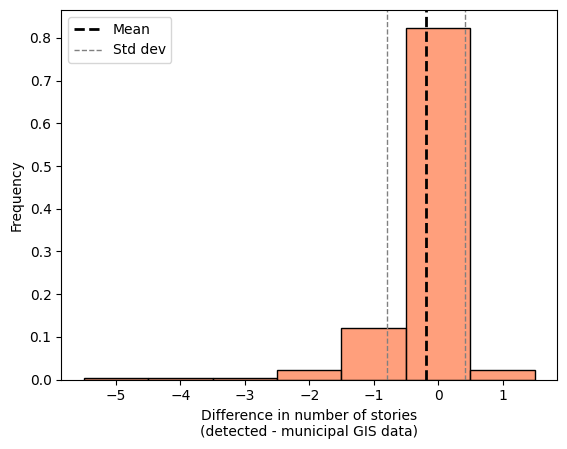

In [16]:
# Histogram of difference in stories
data = detected_grouped['diff_stories']
zero_diff = data.loc[data==0]
print('number of records with zero difference in stories: ', len(zero_diff))
print('number of records: ', len(data))
print('percentage of records with zero difference in stories: ', len(zero_diff)/len(data))
mean = data.mean()
stdev = data.std()
print('mean: ', mean)

ax = sns.histplot(data, bins=6, kde=False, color='coral', stat='proportion', discrete=True)
plt.axvline(mean, color = 'black', linestyle = 'dashed', linewidth = 2, label="Mean")
plt.axvline((mean + stdev), color = 'gray', linestyle = 'dashed', linewidth = 1, label="Std dev")
plt.axvline((mean-stdev), color = 'gray', linestyle = 'dashed', linewidth = 1)
plt.legend(['Mean', 'Std dev'], loc='upper left')
plt.xlabel('Difference in number of stories\n(detected - municipal GIS data)')
plt.ylabel('Frequency')
plt.show()

mean:  -0.5368912447630816


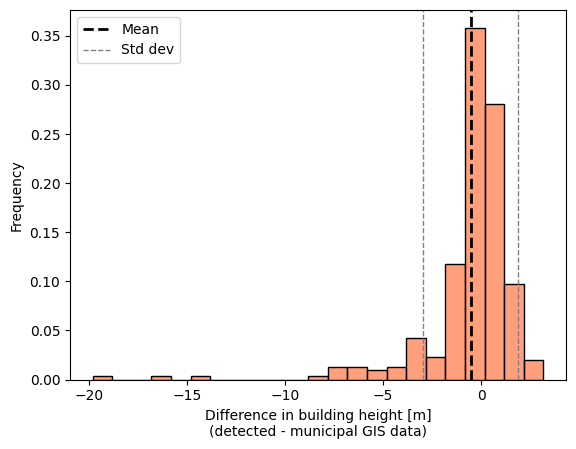

In [17]:
# Histogram of difference in height
data = detected_grouped['diff_height']
mean = data.mean()
stdev = data.std()
print('mean: ', mean)

ax = sns.histplot(data, bins=23, kde=False, color='coral', stat='proportion')
plt.axvline(mean, color = 'black', linestyle = 'dashed', linewidth = 2, label="Mean")
plt.axvline((mean + stdev), color = 'gray', linestyle = 'dashed', linewidth = 1, label="Std dev")
plt.axvline((mean-stdev), color = 'gray', linestyle = 'dashed', linewidth = 1)
plt.legend(['Mean', 'Std dev'], loc='upper left')
plt.xlabel('Difference in building height [m]\n(detected - municipal GIS data)')
plt.ylabel('Frequency')
plt.show()